In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tflearn

from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM


/Users/teikanhei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:

# データ準備
data = pd.read_csv("BTC.csv",
                thousands=',',
                engine='python')
dataframe = data.sort_values('日付け', ascending=True)
dataset = dataframe['終値'].values
dataset = dataset.astype('float32')

# 標準化
dataset -= np.min(np.abs(dataset))
dataset /= np.max(np.abs(dataset))

dataframe

,日付け,終値,始値,高値,安値,前日比%
334,2017年01月01日,114101,111316,114594,108568,2.50
333,2017年01月02日,116707,114101,118165,111027,2.28
332,2017年01月03日,115396,116707,121367,114291,-1.12
331,2017年01月04日,130010,115396,130167,114740,12.66
330,2017年01月05日,112744,130010,139065,101769,-13.28
329,2017年01月06日,108571,112744,137394,98672,-3.70
328,2017年01月07日,105381,108571,114603,95080,-2.94
327,2017年01月08日,110455,105381,112326,95069,4.81
326,2017年01月09日,106400,110455,110746,101983,-3.67
325,2017年01月10日,105266,106400,106400,102437,-1.07


In [5]:

# 算出する値たち
model = None
train_predict = None
test_predict = None

# データセットのパラメータ設定
steps_of_history = 3
steps_in_future = 1

In [6]:

X, Y = [], []
for i in range(0, len(dataset) - steps_of_history,steps_in_future):
    X.append(dataset[i:i + steps_of_history])
    Y.append(dataset[i + steps_of_history])

X = np.reshape(np.array(X), [-1, steps_of_history, 1])
Y = np.reshape(np.array(Y), [-1, 1])



In [7]:
# Build neural network
net = tflearn.input_data(shape=[None, steps_of_history, 1])

In [8]:
# LSTMは時間かかるのでGRU
net = tflearn.gru(net, n_units=6)
net = tflearn.fully_connected(net, 1, activation='linear')


In [9]:
# 回帰の設定
# Adam法で測定
# http://qiita.com/TomokIshii/items/f355d8e87d23ee8e0c7a
# 時系列分析での予測精度の指標にmean_squareを使っている
# mapeが一般的なようだ
# categorical_crossentropy
# mean_square : 二乗平均平方根
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
                loss='mean_square')


In [10]:
# Define model
model = tflearn.DNN(net, tensorboard_verbose=0)


In [11]:
# 今回は80%を訓練データセット、20%をテストデータセットとして扱う。
pos = round(len(X) * (1 - 0.2))
trainX, trainY = X[:pos], Y[:pos]
testX, testY   = X[pos:], Y[pos:]


In [12]:
# Start training (apply gradient descent algorithm)
model.fit(trainX, trainY, validation_set=0.1, show_metric=True, batch_size=1, n_epoch=150, run_id='btc')


Training Step: 35849  | total loss: 0.00020 | time: 1.232s
| Adam | epoch: 150 | loss: 0.00020 - binary_acc: 0.0000 -- iter: 238/239
Training Step: 35850  | total loss: 0.00021 | time: 2.245s
| Adam | epoch: 150 | loss: 0.00021 - binary_acc: 0.0000 | val_loss: 0.00017 - val_acc: 0.0000 -- iter: 239/239
--


In [13]:
# predict
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

In [41]:
 # plot train data
train_predict_plot = np.empty_like(dataset).reshape(len(dataset),1)
train_predict_plot[:, :] = np.nan
train_predict_plot[steps_of_history:len(train_predict) + steps_of_history, :] = train_predict

In [45]:
# plot test data
test_predict_plot = np.empty_like(dataset).reshape(len(dataset),1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + steps_of_history:len(dataset), :] = test_predict

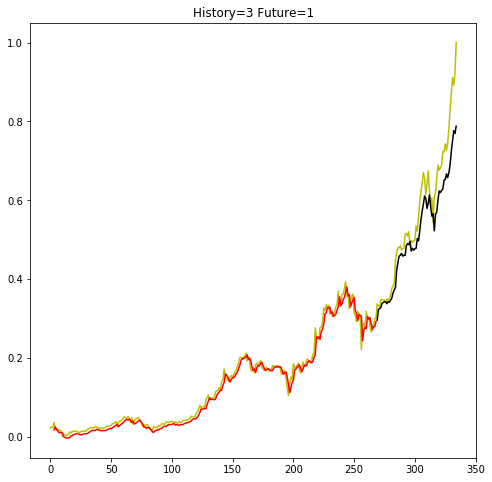

In [50]:
# plot show res
plt.figure(figsize=(8, 8))
plt.title('History={} Future={}'.format(steps_of_history, steps_in_future))
plt.plot(dataset, label="actual", color="y")
plt.plot(train_predict_plot, label="train", color="r")
plt.plot(test_predict_plot, label="test", color="k")
plt.savefig('result.png')
plt.show()

NameError: name 'test_predict_plot' is not defined